# Person classification in artworks Challenge Starting Kit

## Modules and Data

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread # Install scikit-image if needed
from skimage.transform import resize
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import itertools
#Garbage Collector
import gc
## Sklearn
from sklearn.metrics import classification_report,confusion_matrix

## Keras
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import Sequential
from keras.applications import vgg16
from keras.models import Model,load_model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,InputLayer,Dropout,Activation
import keras.optimizers as optimizers
import keras
%matplotlib inline

Using TensorFlow backend.


In [ ]:
## Code to plot confusion matrix from sklearn emprunté à scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

I imported all the data to myDrive so might have to change some of the lines here if you wanna test the functions.
You can access the uploaded data on drive via this link :

https://drive.google.com/drive/folders/1g_PKE-xrBduQ7pGY64w2BbQv3dii4A9o?usp=sharing

In it you will find the data organized in a train file subsidivided in positive and negative class. Test data has also been uploaded.
You will also find some models I trained, but they are not relevant in the following script.

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#For training with Image Gen
cd /content/drive/My Drive/challenge_IMA/data

/content/drive/My Drive/challenge_IMA/data


## Image Generator

In [ ]:
#Parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32 # low batch on Transfer learning -> pretty bad
base_dir = 'train'
augmentation = False #turn on and off if you want to augment the data

In [ ]:
#### Image Generators : don't fill the ram / allow data augmentation
if not(augmentation):
  train_datagen = ImageDataGenerator(
      rescale= 1./255,
      validation_split = 0.2)

if augmentation:
  train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      validation_split = 0.2)


train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle = True, # Data needs shuffling, do not remove
    class_mode= 'binary',
    subset='training')
#Note : data is also augmented in the validation split, due to Keras implementation
validation_generator = train_datagen.flow_from_directory(
    base_dir, # same directory as training data
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle = False,
    class_mode='binary',
    subset='validation')

Found 4001 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


## Basic CNN

**Architecture** :

Starting with a wide and shallow feature space in the first layers, and narrow and deep towards the end. 

In [ ]:
#### Modèle
#Const
nb_classes = 1
learning_rate = 0.001
#Model definition
model = Sequential()

# First Layer
model.add(Conv2D(64, (3,3),input_shape = (IMAGE_SIZE,IMAGE_SIZE,3),strides= (1,1),activation= 'relu',padding ='same',use_bias = True))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

#Second Layer
model.add(Conv2D(128, (3,3),input_shape = (IMAGE_SIZE,IMAGE_SIZE,3),strides= (1,1),activation= 'relu',padding ='same',use_bias = True))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

#Third Layer
model.add(Conv2D(256, (3,3),input_shape = (IMAGE_SIZE,IMAGE_SIZE,3),strides= (1,1),activation= 'relu',padding ='same',use_bias = True))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

#Fourth Layer
model.add(Conv2D(256, (3,3),input_shape = (IMAGE_SIZE,IMAGE_SIZE,3),strides= (1,1),activation= 'relu',padding ='same',use_bias = True))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

#Feature space vector
model.add(Flatten())

#Fully Connected Layers
model.add(Dense(512,activation= 'relu', use_bias = True))
model.add(Dense(512,activation= 'relu', use_bias = True))
model.add(Dense(1,activation = 'sigmoid', use_bias = True))



In [ ]:
#compilation
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

In [ ]:
#### Training

history = model.fit_generator(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps = len(validation_generator))

Epoch 1/10
126/126 [==============================] - 24s 194ms/step - loss: 2551.3786 - accuracy: 0.5651 - val_loss: 1.0189e-04 - val_accuracy: 0.2893
Epoch 2/10
126/126 [==============================] - 23s 179ms/step - loss: 0.9293 - accuracy: 0.6036 - val_loss: 0.4684 - val_accuracy: 0.2893
Epoch 3/10
126/126 [==============================] - 23s 181ms/step - loss: 0.6892 - accuracy: 0.6546 - val_loss: 1.2534 - val_accuracy: 0.7107
Epoch 4/10
126/126 [==============================] - 23s 181ms/step - loss: 129.4814 - accuracy: 0.6216 - val_loss: 9.2768 - val_accuracy: 0.7107
Epoch 5/10
126/126 [==============================] - 23s 179ms/step - loss: 403.8580 - accuracy: 0.6646 - val_loss: 1.0485 - val_accuracy: 0.7107
Epoch 6/10
126/126 [==============================] - 23s 180ms/step - loss: 0.6569 - accuracy: 0.6736 - val_loss: 1.6890 - val_accuracy: 0.7107
Epoch 7/10
126/126 [==============================] - 23s 179ms/step - loss: 0.6404 - accuracy: 0.6961 - val_loss: 1.27

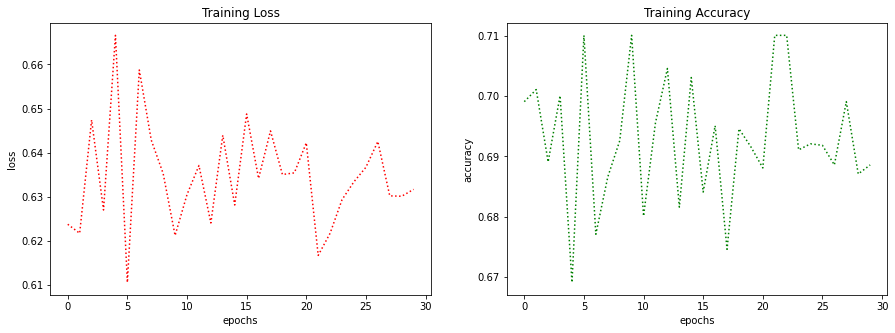

In [ ]:
# Retrieving training data
train_loss = history.history['loss']
train_acc = history.history['acc']

# Plotting learning curve
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,5))
ax1.plot(range(30), train_loss,'y:',color = 'red')
ax1.set_title('Training Loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.plot(range(30), train_acc,'y:',color = 'green')
ax2.set_title('Training Accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
plt.show()

### **Conclusion**
The loss curve is completly erratic, and loss doesn't seem to be willing to go down. Clearly, CNN is not working, the model is not learning. 

**What could be the explanation ?**

What CNN is really good at, is extracting features or patterns from images for instance. If in the MNIST library, it works really well, it's because these pattern are 'easy'. On more complex classification task, such as for CIFAR-10 it shows its limitations. This classification task is, I would say, even more complex than the CIFAR-10 classification, because we're not working on natural images, but paintings. Furthermore, the training set is composed of only 5,000 images, it pales in comparison with the 10,000,000 images on which VGG - 16 is trained for example.

In [ ]:
cd ../To\ upload

/content/drive/My Drive/challenge_IMA/To upload


In [ ]:
## 3 images from positive class
image_1 = imread('IM_000102.jpg')
image_2 = imread('IM_000162.jpg')
image_3 = imread('IM_000194.jpg')

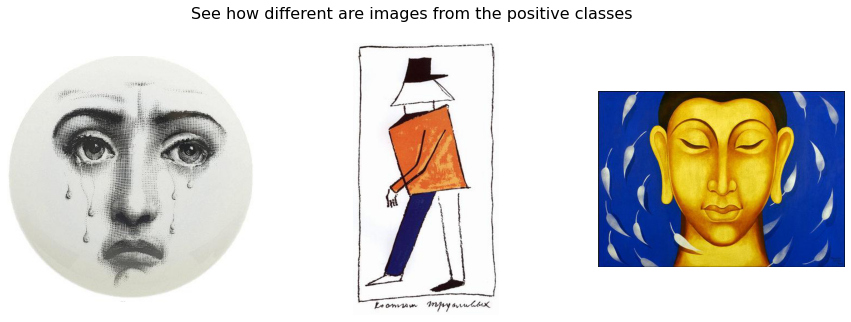

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15,5))
plt.suptitle('See how different are images from the positive classes',size = 16)
ax1.imshow(image_1)
ax1.axis('off')
ax2.imshow(image_2)
ax2.axis('off')
ax3.imshow(image_3)
ax3.axis('off')
plt.show()

CNN won't probably learn what is an eye, a shoe, or a leg from the 1,000 images of the positive class of the training set.

## Transfer learning from VGG

An elegant solution to this problem is to do a 'transfer learning' from a pre-trained convNet.

I read this paper about the topic : http://tiny.cc/encysz
They used a pre-trained convNet to classify objects from paintings and had good results. The idea seemed interesting so I gave it a try. 
The idea is simply to use the feature space from the ConvNet as an input for another classifier. In this space, our classifier is more likely to separate the two classes.

**Parameters** : 

- **learning rate** : it should not be too high, otherwise the model won't find the optimum. I used 1e-5 for testing in general, and 1e-6 to get an optimal score.

- **shallow network layers** : to classify data from the feature extractor, I chose to use a shallow network, because of its easy implementation with Keras. I was quite surprised to notice that adding depth to the model did not improve performance, but quite the opposite. An explanation is that the model might be trying to find relations between the data of the feature map that does not exist.

- **batch size** : A low batch can lead to poor temporal performance and poor f1_score



### Frozen - Training

The first thing I tried was to directly use the feature space of VGG-16 as input of another shallow network, hoping that VGG will find patterns my CNN couldn't find. Hence I'm just training the shallow network. It provides satisfying results : the model learnt something and did not put everything to zero. 

In [ ]:
def building_vgg_model(lr, fine_tuning, trainable_layers = 0,shallow_layers = 1):#I defined a function that builds the model
  '''
  Desc : Builds the transfer learning model
  ----------------------
  Inputs : 
  -> lr : learning rate
  -> fine_tuning : whether or not to freeze the last layers of vgg
  -> trainable_layers : number of conv layers that are unfrozen beginning from the last one
  (expected to be 1 or 2)
  -> shallow_layers : number of shallow layers
  '''
  input_shape = (224,224,3)
  learning_rate = lr
  #Getting vgg
  vgg = vgg16.VGG16(include_top = False, weights='imagenet',input_shape = input_shape)

  #Building Feature extractor
  output = vgg.layers[-1].output #getting last layer output
  output = keras.layers.Flatten()(output)
  vgg_model = Model(vgg.input, output)
  
  #Fine tuning
  if not(fine_tuning):
    #Freezing feature extractor for training
    vgg_model.trainable = False
    for layer in vgg_model.layers:
      layer.trainable = False
  elif trainable_layers == 1:
    vgg_model.trainable = True
    first_layers = vgg_model.layers[:15] #unfreezing just the last layer
    for layer in first_layers:
      layer.trainable = False
  elif trainable_layers == 2:
    vgg_model.trainable = True
    first_layers = vgg_model.layers[:11] #unfreezing the last 2 layers
    for layer in first_layers:
      layer.trainable = False
  
  #Defining the classifier from the feature extractor
  #Parameters
  input_shape =vgg_model.output_shape[1] 

  #Model
  model = Sequential()
  model.add(vgg_model)
  model.add(Dense(4096,activation='relu',input_dim = input_shape)) #with
  model.add(Dropout(0.1))
  
  while shallow_layers >= 2:
    model.add(Dense(4096,activation='relu',input_dim = input_shape))
    model.add(Dropout(0.1))
    shallow_layers -=1

  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(learning_rate=learning_rate),metrics = ['accuracy'])

  return model
    




In [ ]:
model = building_vgg_model(1e-5, False)

In [ ]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_data=validation_generator,
                    validation_steps = len(validation_generator))

Epoch 1/15
126/126 [==============================] - 26s 206ms/step - loss: 0.5343 - accuracy: 0.7461 - val_loss: 0.6663 - val_accuracy: 0.7908
Epoch 2/15
126/126 [==============================] - 24s 189ms/step - loss: 0.4167 - accuracy: 0.8265 - val_loss: 0.4389 - val_accuracy: 0.7848
Epoch 3/15
126/126 [==============================] - 24s 190ms/step - loss: 0.3341 - accuracy: 0.8608 - val_loss: 0.3522 - val_accuracy: 0.7568
Epoch 4/15
126/126 [==============================] - 24s 192ms/step - loss: 0.2809 - accuracy: 0.8883 - val_loss: 1.0489 - val_accuracy: 0.8078
Epoch 5/15
126/126 [==============================] - 24s 189ms/step - loss: 0.2483 - accuracy: 0.9040 - val_loss: 0.7100 - val_accuracy: 0.8208
Epoch 6/15
126/126 [==============================] - 24s 189ms/step - loss: 0.2167 - accuracy: 0.9238 - val_loss: 0.8171 - val_accuracy: 0.8238
Epoch 7/15
126/126 [==============================] - 24s 191ms/step - loss: 0.1798 - accuracy: 0.9403 - val_loss: 1.1978 - val_ac

### Frozen - Evaluation

In [ ]:
def evaluate():
  # Retrieving training data
  train_loss = history.history['loss']
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  # Plotting learning curve
  fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,5))
  ax1.plot(range(15), train_loss,'y--',color = 'red',label = 'train_loss')
  ax1.plot(range(15), val_loss,'y--',color = 'green', label = 'val_loss')
  ax1.set_title('Training Loss')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.legend()
  ax2.plot(range(15), train_acc,'y--',color = 'red',label = 'train_acc')
  ax2.plot(range(15), val_acc,'y--',color = 'green', label = 'val_acc')
  ax2.legend()
  ax2.set_title('Training Accuracy')
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('accuracy')
  plt.show()

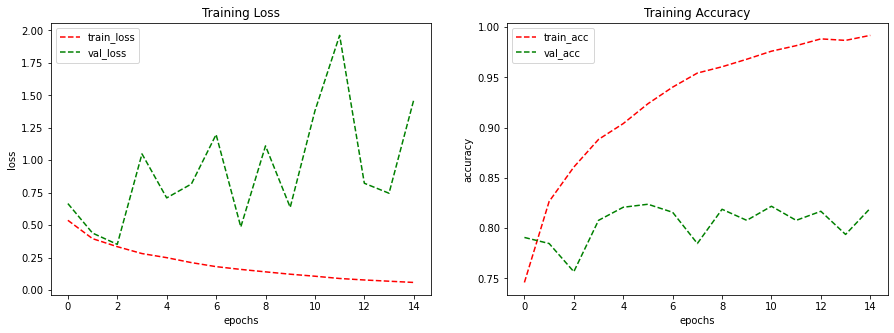

In [ ]:
evaluate()

After a few epochs the model is overfitting

In [ ]:
## Classification report on validation data
y_pred = model.predict_generator(validation_generator)
y_classes = y_pred>.5
y_classes = y_classes.astype('uint8')
y_true = validation_generator.classes
print(classification_report(y_true,y_classes))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       710
           1       0.79      0.52      0.62       289

    accuracy                           0.82       999
   macro avg       0.81      0.73      0.75       999
weighted avg       0.82      0.82      0.81       999



Confusion matrix, without normalization
[[669  41]
 [139 150]]


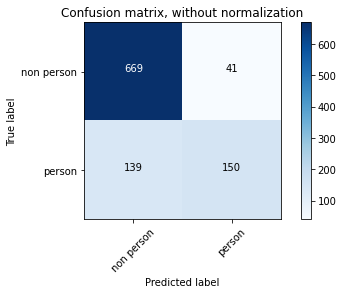

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non person','person'],
                      title='Confusion matrix, without normalization')

The model still has difficulties recognizing people. What's good however is that **recall is very good** for the non person class.

### Unfrozen - Training

Another interesting idea is to adapt a little bit the feature space to this problem, by allowing training on the deeper layers. 

The first layers should not be touched otherwise the model as they do a great job recognizing features that are independant of this problem. 

 For that to work, it is necessary you take a very low learning rate in order not to completly change the weights of the deeper layers. 

In the following we unfreeze the last two layers 4 and 5 of VGG.

In [ ]:
model = building_vgg_model(1e-6, True) # I chose a lower learning rate

In [ ]:
#Now it's in the hands of god
history = model.fit_generator(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_data=validation_generator,
                    validation_steps = len(validation_generator))

Epoch 1/15
126/126 [==============================] - 37s 293ms/step - loss: 0.5723 - accuracy: 0.7126 - val_loss: 0.9796 - val_accuracy: 0.7688
Epoch 2/15
126/126 [==============================] - 35s 277ms/step - loss: 0.4802 - accuracy: 0.7773 - val_loss: 1.0384 - val_accuracy: 0.7848
Epoch 3/15
126/126 [==============================] - 35s 277ms/step - loss: 0.4181 - accuracy: 0.8108 - val_loss: 0.8450 - val_accuracy: 0.8158
Epoch 4/15
126/126 [==============================] - 35s 277ms/step - loss: 0.3701 - accuracy: 0.8473 - val_loss: 0.8533 - val_accuracy: 0.8238
Epoch 5/15
126/126 [==============================] - 35s 277ms/step - loss: 0.3212 - accuracy: 0.8693 - val_loss: 0.8627 - val_accuracy: 0.8318
Epoch 6/15
126/126 [==============================] - 35s 277ms/step - loss: 0.2803 - accuracy: 0.8915 - val_loss: 0.7816 - val_accuracy: 0.8338
Epoch 7/15
126/126 [==============================] - 35s 276ms/step - loss: 0.2468 - accuracy: 0.9058 - val_loss: 0.6259 - val_ac

### Unfrozen - Evalutation

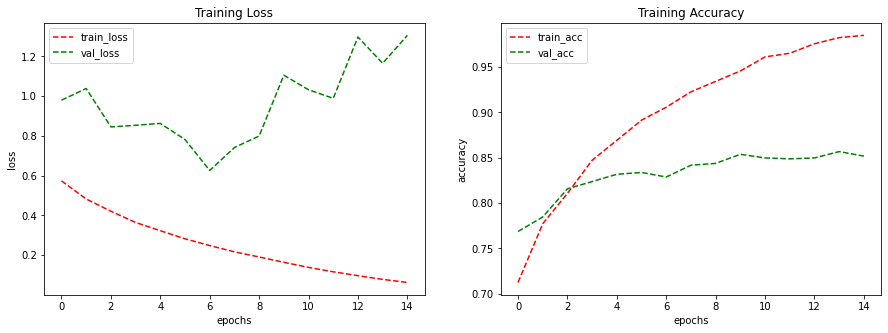

In [ ]:
evaluate()

In [ ]:
## Classification report on validation data
y_pred = model.predict_generator(validation_generator)
y_classes = y_pred>.5
y_classes = y_classes.astype('uint8')
y_true = validation_generator.classes
print(classification_report(y_true,y_classes))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       710
           1       0.81      0.64      0.72       289

    accuracy                           0.85       999
   macro avg       0.84      0.79      0.81       999
weighted avg       0.85      0.85      0.85       999



Unfreezing provides overall better results on precision and recall of the person class while still mainting the precision and recall of the non person class. Given the lower learning rate, the model did not overfit after a few epochs.

### With augmentation

**Augmentation** :

The problem with our data set as we saw, is that it is composed of only a few samples (1000 samples for the positive class). A great idea is to try to extend this data set by doing rotations or translations... It's directly implemented in Keras ImageDataGenerator. 
I did rotate the images of 20 degrees and I did an horizontal shift.

In most cases I found augmentation led to poor performance on this data set. The explanation might be that it adds a lot of complexity to the model and make patterns appear that are not in the validation images. Let's take an example : in most images of a face or a human, an eyebrow is at the top of an eye. Deriving this pattern from the data might be a good way to recognize a face for the network. With data augmentation, such pattern cannot be learnt.

Yet, at last, for the last model, it seemed to work well. Frankly I have no explanation why it worked this time.  

I augmented the data by setting augmentation to True. Learning rate was set to 1e-6, but given that the training sample was heavier I trained on more epochs, with only one layer of shallow network.

*Note : You can find the following model here :*
https://drive.google.com/file/d/1-Eb0n7c8KlDQaZFp13A2i2yK2dfcH77t/view?usp=sharing

In [ ]:
model = load_model('Fine_tuned_VGG_6_last_layers_lr_6_aug_sh1.h5') ## Training time was very long, sorry I didn't put it

In [ ]:
## Classification report on validation data
y_pred = model.predict_generator(validation_generator)
y_classes = y_pred>.5
y_classes = y_classes.astype('uint8')
y_true = validation_generator.classes
print(classification_report(y_true,y_classes))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       710
           1       0.79      0.76      0.77       289

    accuracy                           0.87       999
   macro avg       0.85      0.84      0.84       999
weighted avg       0.87      0.87      0.87       999



Results are better, suprising as it seems. I mean, I tested augmentation more than once, and it did not always provide better results compared to non augmented models. 

The reason for the improvement is that making shifts and rotations on the data improved a lot recall on person class, all other things nearly equal.

In [ ]:
import random # Not necessity for you
for Id in df_submission['name']:
    value = random.randint(0,1) # Draw a random number between 0 and 1 : binary classification : put here the result of
                                # your classifier
    df_submission.loc[df_submission['name'] == Id, 'person'] = value
df_submission['person'] = df_submission['person'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('data/exemple_test.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

## Cleaning memory

In [ ]:
#Useful when training models
del model
gc.collect()

35450

# Saving file

Example to fill the file and save it.

In [ ]:
test_datagen= ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    directory="test",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False,
)

Found 5000 images belonging to 1 classes.


In [ ]:
y_pred = model.predict_generator(test_generator)
y_classes = y_pred>.5
y_classes = y_classes.astype('uint8')

In [ ]:
df_submission = pd.read_csv('test.csv')

        name  person
0  IM_005000     NaN
1  IM_005001     NaN
2  IM_005002     NaN
3  IM_005003     NaN


In [ ]:
import random # Not necessity for you
for Id in df_submission['name']:
    index = int(Id[-4:])%5000
    value = y_classes[index] # Draw a random number between 0 and 1 : binary classification : put here the result of
                                # your classifier
    df_submission.loc[df_submission['name'] == Id, 'person'] = value
df_submission['person'] = df_submission['person'].astype(int) # This line is mandatory to be sure to have integer
print(df_submission.head(3))
df_submission.to_csv('exemple_test.csv', index=None, sep=',', mode='w') # Save the data in the exemple_test.csv file

        name  person
0  IM_005000       1
1  IM_005001       0
2  IM_005002       0
